In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index().drop('level_0', axis=1)
    merged = pd.merge(
        df, source_data[group_columns],
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [7]:
data = pd.read_csv('../data/UCBadmit.csv', sep=';').reset_index(drop=True)

dept_idx = (
    data.dept.drop_duplicates().sort_values().reset_index(drop=True).reset_index()
    .set_index('dept')['index'].rename('dept_i').to_frame()
)

data = pd.merge(
    data,
    dept_idx,
    left_on='dept',
    right_index=True)

data = data.assign(
    is_male=(data['applicant.gender'] == 'male').astype('int'),
    ratio=data.admit / data.applications)

num_depts = dept_idx.shape[0]

data

,dept,applicant.gender,admit,reject,applications,dept_i,is_male,ratio
0,A,male,512,313,825,0,1,0.620606
1,A,female,89,19,108,0,0,0.824074
2,B,male,353,207,560,1,1,0.630357
3,B,female,17,8,25,1,0,0.680000
4,C,male,120,205,325,2,1,0.369231
5,C,female,202,391,593,2,0,0.340641
6,D,male,138,279,417,3,1,0.330935
7,D,female,131,244,375,3,0,0.349333
8,E,male,53,138,191,4,1,0.277487
9,E,female,94,299,393,4,0,0.239186


In [8]:
with pm.Model() as m13_2:
    a = pm.Normal('a', mu=0, sd=1)
    b_gender = pm.Normal('b_gender', mu=0, sd=1)
    dept_sd_bar = pm.Exponential('dept_sd_bar', lam=1)

    dept = pm.Normal('dept', mu=0, sd=dept_sd_bar,
                     shape=num_depts)

    p_i = pm.Deterministic(
        'p_i',
        pm.math.invlogit(
            -0.5
            + a
            + dept[data.dept_i.values]
            + b_gender * data.is_male.values
        )
    )

    obs = pm.Binomial('obs', n=data.applications, p=p_i,
                      observed=data.admit.values)

    m13_2.name = 'varying intercepts'
    m13_2.trace = pm.sample(2000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/petrushev/.theano/compiledir_Linux-5.1-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [dept, dept_sd_bar, b_gender, a]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:28<00:00, 283.36draws/s]
The acceptance probability does not match the target. It is 0.7010207714015085, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


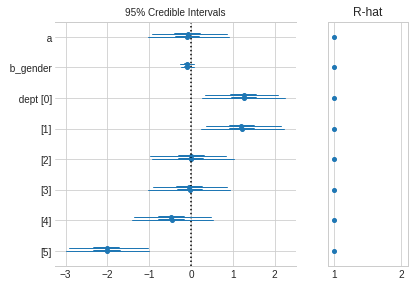

In [9]:
pm.forestplot(m13_2.trace, varnames=['a', 'b_gender', 'dept'])
None

In [11]:
with pm.Model() as m13_3:
    a = pm.Normal('a', mu=0, sd=2)

    K_dept = pm.LKJCholeskyCov(
        'K_dept', n=2, eta=1,
        sd_dist=pm.Exponential.dist(lam=1, shape=2)
    )
 
    dept = pm.MvNormal(
        'dept', mu=[0, 0],
        chol=pm.expand_packed_triangular(2, K_dept),
        shape=(num_depts, 2)
    )
    
    dept_a = pm.Deterministic('dept_a', dept[:, 0])
    dept_male = pm.Deterministic('dept_male', dept[:, 1])

    p_i = pm.Deterministic(
        'p_i',
        pm.math.invlogit(
            dept_a[data.dept_i.values]
            + dept_male[data.dept_i.values] * data.is_male.values
        )
    )

    obs = pm.Binomial('obs', n=data.applications, p=p_i,
                      observed=data.admit.values)

    m13_3.name = 'covariate departments'
    m13_3.trace = pm.sample(2000, tune=2500, chains=2)

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/petrushev/.theano/compiledir_Linux-5.1-arch1-1-ARCH-x86_64-wi

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


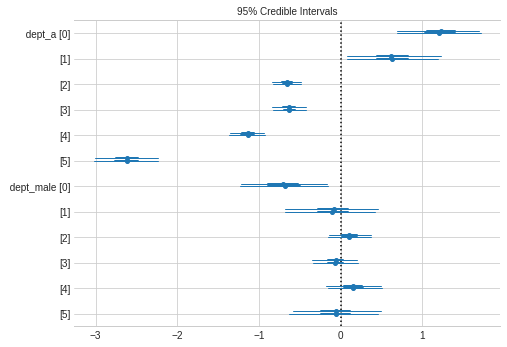

In [13]:
plt.figure(figsize=(8, 5))
pm.forestplot(m13_3.trace, varnames=['dept_a', 'dept_male'], rhat=False)
None

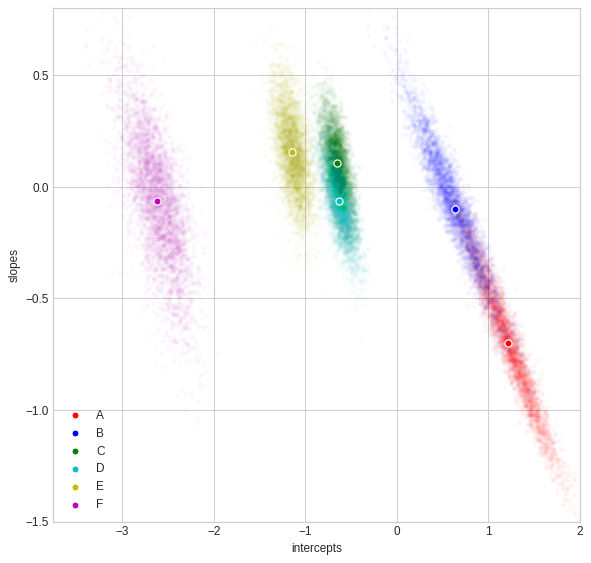

In [43]:
plt.figure(figsize=(8, 8), dpi=85)

for c, _i in zip('rbgcym', dept_idx.dept_i):
    _a = m13_3.trace['dept_a'][:, _i]
    _male = m13_3.trace['dept_male'][:, _i]

    plt.scatter(_a, _male,
                c=c, marker='.', alpha=.02, label='')
    
for label, c, _a, _male in zip(
        dept_idx.index, 'rbgcym',
        m13_3.trace['dept_a'].mean(axis=0),
        m13_3.trace['dept_male'].mean(axis=0)):
    plt.scatter(_a, _male, facecolor=c, edgecolor='white',
                marker='o', alpha=1, label=label)

plt.legend(loc='lower left')
plt.gca().set(xlabel='intercepts', ylabel='slopes',
              xlim=(None, 2), ylim=(-1.5, .8))
None

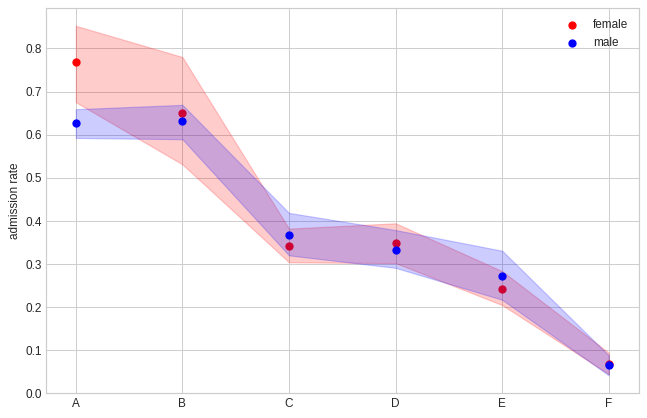

In [72]:
tmp = agg_prediction(m13_3.trace['p_i'], data, ['dept_i', 'is_male'], summarize())

plt.figure(figsize=(9, 6), dpi=85)

plt.scatter(tmp[tmp.is_male == 0].dept_i, tmp[tmp.is_male == 0].mean_, color='r', label='female')
plt.fill_between(tmp[tmp.is_male == 0].dept_i, tmp[tmp.is_male == 0].lower, tmp[tmp.is_male == 0].upper,
                 alpha=.2, color='r')

plt.scatter(tmp[tmp.is_male == 1].dept_i, tmp[tmp.is_male == 1].mean_ , color='b', label='male')
plt.fill_between(tmp[tmp.is_male == 1].dept_i, tmp[tmp.is_male == 1].lower, tmp[tmp.is_male == 1].upper,
                 alpha=.2, color='b')

plt.legend()
plt.gca().set(xticks=dept_idx.dept_i, xticklabels=list(dept_idx.index),
              ylabel='admission rate', ylim=(0, None))

None

In [44]:
pm.compare({
    m13_3: m13_3.trace,
    m13_2: m13_2.trace,
})

INFO (theano.gof.compilelock): Refreshing lock /home/petrushev/.theano/compiledir_Linux-5.1-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
covariate departments,93.57,7.91,0,1,6.26,0,1
varying intercepts,108.79,9.52,15.22,0,16.05,10.57,1
